# Final training of convolutionnal neural networks (CNNs)

In this notebook, we train the CNNs such as AlexNet, VGG11, ... Our baseline is also trained in this notebook. The trained data is under amplitude and chi-square limitations. The CNNs are trained over a balanced dataset of 10 000 samples with a fraction of 85\% for the training. Different training time were set as some models had room for improvement while beeing not too computationnal costly. The Adam optimizer Adam is used in some cases to speed up the learning process.
The setting for the training are :
 * batch size : 64 
 * train size : 85\%
 * number of samples : 10 000

Final best results :

    * Baseline model
        Epoch : 20 - AUCROC : 0.981 
        AUROC Mass : 0.998 - AUROC Source : 0.965


## 0. Import

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

import torch
from torch.utils.data import DataLoader
import torch.nn as nn


from helpers.data_generation.file_management import read_hdf5
from helpers.data_generation.error_generation_chi2 import Residual, CombineDataset
from helpers.model.helpers_model import NeuralNet
from sklearn.metrics import roc_auc_score, roc_curve

import warnings
warnings.filterwarnings('ignore') 

## 1. Preparating the dataset

In [5]:
size = 10000
ratio = 0.75; percent = np.array([0.005, 0.015, 0.005])

res = Residual()
res.build(size, ratio = ratio, per_error = percent)

print('Data Generation Finished')

Data Generation Finished


In [6]:
metadata = pd.DataFrame()
size = 10000
ratio = 0.75; percent = np.array([0.005, 0.015, 0.005])

str_ID =  "S"+str(size)+"R"+str(int(ratio*100))
[final_array, metadata] = read_hdf5(str_ID)
metadata ['ID'] = np.arange(0,final_array.shape[0])

data_set = CombineDataset(metadata,'ID','class',final_array, True)

data_train, data_test = train_test_split(data_set,train_size=0.85,random_state=42)

batch_size = 64; max_epoch = 30


loader_train = DataLoader(data_train, batch_size = batch_size, 
                          num_workers = 8, drop_last=True, pin_memory = True)
loader_test = DataLoader(data_test, batch_size = batch_size, 
                         num_workers = 8, drop_last=True, pin_memory = True)
print('Reading Data Finished')

Reading Data Finished


## 2. Convolutionnal neural network (CNN)
### 2.0 Baseline

Results :
* Baseline : 
    * Maximum number of epoch : 50
    * Epoch : 20 - AUCROC : 0.981 
    * AUROC Mass : 0.998 - AUROC Source : 0.965


Finished Training - Baseline


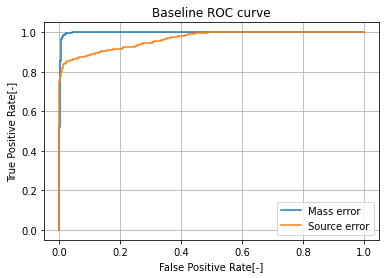

Epoch : 20
ROC mass : 0.998 - ROC source : 0.965


In [7]:
netbasic = NeuralNet('BasicCNN', 'SGD/momentum')
netbasic.load_checkpoint('_current')
while len(netbasic.epoch_metric) < max_epoch:  
    netbasic.train(loader_train)
    res = netbasic.test(loader_test)
    print("Epoch : "+str(netbasic.current_epoch))

print('Finished Training - Baseline')


netbasic.load_checkpoint('_optimal')
with torch.no_grad():
    predictions = []
    targets = []
    for data in loader_test:
        images, _, labels = data
        outputs = netbasic.net(images)

        predictions.extend(outputs.cpu().numpy())
        targets.extend(labels.cpu().numpy())
        result = netbasic.calculate_metrics(np.round(np.array(predictions)), np.array(targets))
    predictions = np.array(predictions); targets = np.array(targets)
        
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(targets[:,0], predictions[:,0])
lr_fpr, lr_tpr, _ = roc_curve(targets[:,1], predictions[:,1])
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, label='Mass error')
plt.plot(lr_fpr, lr_tpr, label='Source error')
# axis labels
plt.xlabel('False Positive Rate[-]')
plt.ylabel('True Positive Rate[-]')
# show the legend
plt.legend()
plt.grid()
plt.title('Baseline ROC curve')
plt.savefig("figures/cnn/Baseline_roc.png")
# show the plot
plt.show()

print('Epoch :', len(netbasic.epoch_metric))
print('ROC mass : {:.3f} - ROC source : {:.3f}'.format(roc_auc_score(targets[:,0], predictions[:,0],average='samples'), 
                                                       roc_auc_score(targets[:,1], predictions[:,1],average='samples')))

### 2.1. Spatial exploitation CNN

Results :
* AlexNet :  
    * Maximum number of epoch : 50
    * Epoch : 50 - AUCROC : 0.968 
    * AUROC Mass : 0.998 - AUROC Source : 0.938
* VGG11 :  
    * Maximum number of epoch : 30
    * Epoch : 16 - AUCROC : 0.982 
    * AUROC Mass : 0.999 - AUROC Source : 0.964
* GoogleNet :  
    * Maximum number of epoch : 30
    * Epoch : 30 - AUCROC : 0.973 
    * AUROC Mass : 0.999 - AUROC Source : 0.946

#### AlexNet

Finished Training - AlexNet


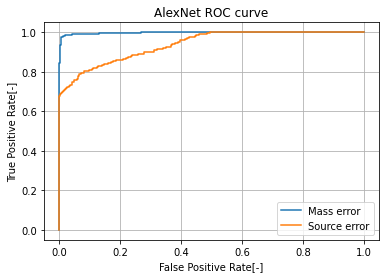

Epoch : 50
ROC mass : 0.998 - ROC source : 0.938


In [8]:
netbasic = NeuralNet('AlexNet', 'SGD/momentum')
netbasic.load_checkpoint('_current')
while len(netbasic.epoch_metric) < max_epoch:
    netbasic.train(loader_train)
    res = netbasic.test(loader_test)
    print("Epoch : ", len(netbasic.epoch_metric))
    
print('Finished Training - AlexNet')

netbasic.load_checkpoint('_optimal')
with torch.no_grad():
    predictions = []
    targets = []
    for data in loader_test:
        images, _, labels = data
        m = nn.ZeroPad2d(80)
        outputs = netbasic.net(m(images))

        predictions.extend(outputs.cpu().numpy())
        targets.extend(labels.cpu().numpy())
        result = netbasic.calculate_metrics(np.round(np.array(predictions)), np.array(targets))
    predictions = np.array(predictions); targets = np.array(targets)
        
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(targets[:,0], predictions[:,0])
lr_fpr, lr_tpr, _ = roc_curve(targets[:,1], predictions[:,1])
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, label='Mass error')
plt.plot(lr_fpr, lr_tpr, label='Source error')
# axis labels
plt.xlabel('False Positive Rate[-]')
plt.ylabel('True Positive Rate[-]')
# show the legend
plt.legend()
plt.grid()
plt.title('AlexNet ROC curve')
plt.savefig("figures/cnn/AlexNet_roc.png")
# show the plot
plt.show()

print('Epoch :', len(netbasic.epoch_metric))
print('ROC mass : {:.3f} - ROC source : {:.3f}'.format(roc_auc_score(targets[:,0], predictions[:,0],average='samples'), 
                                                       roc_auc_score(targets[:,1], predictions[:,1],average='samples')))

#### VGG11

Finished Training - VGG11


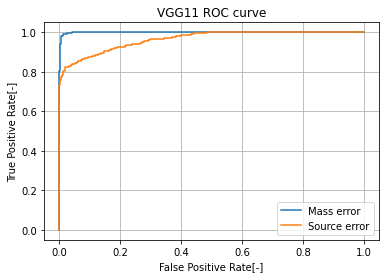

Epoch : 16
ROC mass : 0.999 - ROC source : 0.964


In [9]:
test_acc = np.zeros(max_epoch); 
netbasic = NeuralNet('VGG11', 'Adam')
netbasic.load_checkpoint('_current')

while len(netbasic.epoch_metric) < max_epoch:
    netbasic.train(loader_train, resize_tp = 'Padding')
    res = netbasic.test(loader_test)
    print("Epoch : ", len(netbasic.epoch_metric))
    
print('Finished Training - VGG11')

netbasic.load_checkpoint('_optimal')
with torch.no_grad():
    predictions = []
    targets = []
    for data in loader_test:
        images, _, labels = data
        m = nn.ZeroPad2d(80)
        outputs = netbasic.net(m(images))

        predictions.extend(outputs.cpu().numpy())
        targets.extend(labels.cpu().numpy())
        result = netbasic.calculate_metrics(np.round(np.array(predictions)), np.array(targets))
    predictions = np.array(predictions); targets = np.array(targets)
        
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(targets[:,0], predictions[:,0])
lr_fpr, lr_tpr, _ = roc_curve(targets[:,1], predictions[:,1])
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, label='Mass error')
plt.plot(lr_fpr, lr_tpr, label='Source error')
# axis labels
plt.xlabel('False Positive Rate[-]')
plt.ylabel('True Positive Rate[-]')
# show the legend
plt.legend()
plt.grid()
plt.title('VGG11 ROC curve')
plt.savefig("figures/cnn/VGG11_roc.png")
# show the plot
plt.show()

print('Epoch :', len(netbasic.epoch_metric))
print('ROC mass : {:.3f} - ROC source : {:.3f}'.format(roc_auc_score(targets[:,0], predictions[:,0],average='samples'), 
                                                       roc_auc_score(targets[:,1], predictions[:,1],average='samples')))

#### GoogleNet

Finished Training - GoogleNet


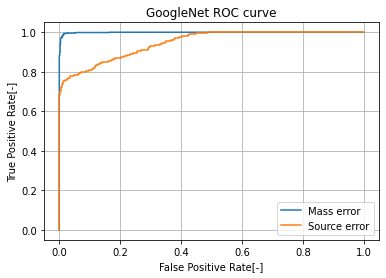

Epoch : 30
ROC mass : 0.999 - ROC source : 0.946


In [10]:
netbasic = NeuralNet('GoogleNet', 'SGD/momentum')
netbasic.load_checkpoint('_current')
while len(netbasic.epoch_metric) < max_epoch:
    netbasic.train(loader_train, resize_tp = 'Padding')
    res = netbasic.test(loader_test)

print('Finished Training - GoogleNet')
    
netbasic.load_checkpoint('_optimal')
with torch.no_grad():
    predictions = []
    targets = []
    for data in loader_test:
        images, _, labels = data
        m = nn.ZeroPad2d(80)
        outputs, _, _ = netbasic.net(m(images))

        predictions.extend(outputs.cpu().numpy())
        targets.extend(labels.cpu().numpy())
        result = netbasic.calculate_metrics(np.round(np.array(predictions)), np.array(targets))
    predictions = np.array(predictions); targets = np.array(targets)
        
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(targets[:,0], predictions[:,0])
lr_fpr, lr_tpr, _ = roc_curve(targets[:,1], predictions[:,1])
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, label='Mass error')
plt.plot(lr_fpr, lr_tpr, label='Source error')
# axis labels
plt.xlabel('False Positive Rate[-]')
plt.ylabel('True Positive Rate[-]')
# show the legend
plt.legend()
plt.grid()
plt.title('GoogleNet ROC curve')
plt.savefig("figures/cnn/GoogleNet_roc.png")
# show the plot
plt.show()

print('Epoch :', len(netbasic.epoch_metric))
print('ROC mass : {:.3f} - ROC source : {:.3f}'.format(roc_auc_score(targets[:,0], predictions[:,0],average='samples'), 
                                                       roc_auc_score(targets[:,1], predictions[:,1],average='samples')))

### 2.2. Multi-path exploitation CNN

Results :
* ResNet18 :  
    * Maximum number of epoch : 50
    * Epoch : 39 - AUCROC : 0.988 
    * AUROC Mass : 0.999 - AUROC Source : 0.961
* DenseNet121 :  
    * Maximum number of epoch : 30
    * Epoch : 21 - AUCROC : 0.979 
    * AUROC Mass : 0.998 - AUROC Source : 0.959

#### ResNet18

Finished Training - ResNet18


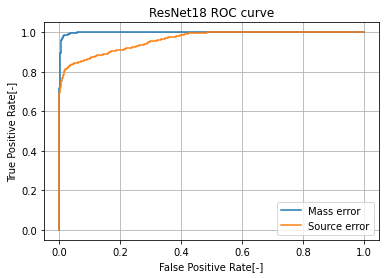

Epoch : 39
ROC mass : 0.999 - ROC source : 0.961


In [11]:
netbasic = NeuralNet('ResNet18', 'SGD/momentum')
netbasic.load_checkpoint('_current')
while len(netbasic.epoch_metric) < max_epoch:
    netbasic.train(loader_train)
    res = netbasic.test(loader_test)
    print("Epoch: ", len(netbasic.epoch_metric))

print('Finished Training - ResNet18')

netbasic.load_checkpoint('_optimal')
with torch.no_grad():
    predictions = []
    targets = []
    for data in loader_test:
        images, _, labels = data
        m = nn.ZeroPad2d(80)
        outputs = netbasic.net(m(images))

        predictions.extend(outputs.cpu().numpy())
        targets.extend(labels.cpu().numpy())
        result = netbasic.calculate_metrics(np.round(np.array(predictions)), np.array(targets))
    predictions = np.array(predictions); targets = np.array(targets)
        
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(targets[:,0], predictions[:,0])
lr_fpr, lr_tpr, _ = roc_curve(targets[:,1], predictions[:,1])
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, label='Mass error')
plt.plot(lr_fpr, lr_tpr, label='Source error')
# axis labels
plt.xlabel('False Positive Rate[-]')
plt.ylabel('True Positive Rate[-]')
# show the legend
plt.legend()
plt.grid()
plt.title('ResNet18 ROC curve')
plt.savefig("figures/cnn/ResNet18_roc.png")
# show the plot
plt.show()

print('Epoch :', len(netbasic.epoch_metric))
print('ROC mass : {:.3f} - ROC source : {:.3f}'.format(roc_auc_score(targets[:,0], predictions[:,0],average='samples'), 
                                                       roc_auc_score(targets[:,1], predictions[:,1],average='samples')))

#### DenseNet121

Finished Training - DenseNet121


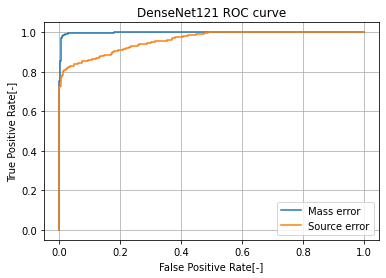

Epoch : 21
ROC mass : 0.998 - ROC source : 0.959


In [12]:
netbasic = NeuralNet('DenseNet121', 'Adam')
netbasic.load_checkpoint('_current')
while len(netbasic.epoch_metric) < max_epoch:
    netbasic.train(loader_train, resize_tp = 'Padding')
    res = netbasic.test(loader_test)
    print("Epoch: ", len(netbasic.epoch_metric))

print('Finished Training - DenseNet121')

netbasic.load_checkpoint('_optimal')
with torch.no_grad():
    predictions = []
    targets = []
    for data in loader_test:
        images, _, labels = data
        m = nn.ZeroPad2d(80)
        outputs = netbasic.net(m(images))

        predictions.extend(outputs.cpu().numpy())
        targets.extend(labels.cpu().numpy())
        result = netbasic.calculate_metrics(np.round(np.array(predictions)), np.array(targets))
    predictions = np.array(predictions); targets = np.array(targets)
        
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(targets[:,0], predictions[:,0])
lr_fpr, lr_tpr, _ = roc_curve(targets[:,1], predictions[:,1])
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, label='Mass error')
plt.plot(lr_fpr, lr_tpr, label='Source error')
# axis labels
plt.xlabel('False Positive Rate[-]')
plt.ylabel('True Positive Rate[-]')
# show the legend
plt.legend()
plt.grid()
plt.title('DenseNet121 ROC curve')
plt.savefig("figures/cnn/DenseNet121_roc.png")
# show the plot
plt.show()

print('Epoch :', len(netbasic.epoch_metric))
print('ROC mass : {:.3f} - ROC source : {:.3f}'.format(roc_auc_score(targets[:,0], predictions[:,0],average='samples'), 
                                                       roc_auc_score(targets[:,1], predictions[:,1],average='samples')))

### 2.3. Ressource limited CNNs
Result :
* SqueezeNet :  
    * Maximum number of epoch : 50
    * Epoch : 50 - AUCROC : 0.917 
    * AUROC Mass : 0.954 - AUROC Source : 0.879

#### SqueezeNet

Finished Training - SqueezeNet


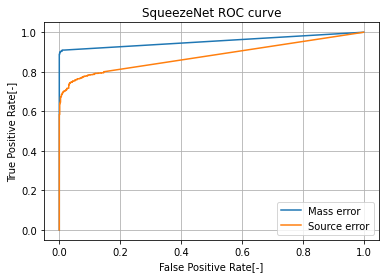

Epoch : 50
ROC mass : 0.954 - ROC source : 0.879


In [13]:
netbasic = NeuralNet('SqueezeNet', 'Adam')
netbasic.load_checkpoint('_current')
while len(netbasic.epoch_metric) < max_epoch:
    netbasic.train(loader_train, resize_tp = 'Padding')
    res = netbasic.test(loader_test)
    print("Epoch: ", len(netbasic.epoch_metric))

print('Finished Training - SqueezeNet')
    
with torch.no_grad():
    predictions = []
    targets = []
    for data in loader_test:
        images, _, labels = data
        m = nn.ZeroPad2d(80)
        outputs = netbasic.net(m(images))

        predictions.extend(outputs.cpu().numpy())
        targets.extend(labels.cpu().numpy())
        result = netbasic.calculate_metrics(np.round(np.array(predictions)), np.array(targets))
    predictions =np.array(predictions); targets = np.array(targets)
        
from sklearn.metrics import roc_curve, roc_auc_score
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(targets[:,0], predictions[:,0])
lr_fpr, lr_tpr, _ = roc_curve(targets[:,1], predictions[:,1])
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, label='Mass error')
plt.plot(lr_fpr, lr_tpr, label='Source error')
# axis labels
plt.xlabel('False Positive Rate[-]')
plt.ylabel('True Positive Rate[-]')
# show the legend
plt.legend()
plt.grid()
plt.title('SqueezeNet ROC curve')
plt.savefig("figures/cnn/SqueezeNet_roc.png")
# show the plot
plt.show()

print('Epoch :', len(netbasic.epoch_metric))
print('ROC mass : {:.3f} - ROC source : {:.3f}'.format(roc_auc_score(targets[:,0], predictions[:,0],average='samples'), 
                                                       roc_auc_score(targets[:,1], predictions[:,1],average='samples')))

## 3. Training plot

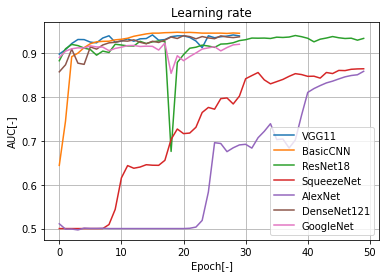

In [14]:
model_list = ['VGG11', 'BasicCNN', 'ResNet18', 'SqueezeNet', 'AlexNet', 'DenseNet121', 'GoogleNet']

plt.figure()
for model_name in model_list:
    netbasic = NeuralNet(model_name, 'SGD/momentum')
    netbasic.load_checkpoint('_current')
    plt.plot(netbasic.epoch_metric, label = model_name)

plt.xlabel('Epoch[-]')
plt.ylabel('AUC[-]')
# show the legend
plt.legend()
plt.grid()
plt.title('Learning rate')
plt.savefig("figures/cnn/Learning_rate.png")
plt.show()